In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/2024_Work/IIIT-Delhi_precog/5kdata.zip /content/

In [ ]:
!unzip 5kdata.zip

In [4]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
from pathlib import Path

image_path=Path("/content/5kdata")

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/5kdata/train'), PosixPath('/content/5kdata/test'))

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 93.2MB/s]


In [7]:
auto_transforms = weights.transforms()
auto_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_data = datasets.ImageFolder(train_dir, transform=auto_transforms)
test_data = datasets.ImageFolder(test_dir, transform=auto_transforms)

train_dataloader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False, # don't need to shuffle test data
    num_workers=4,
    pin_memory=True,
)

class_names = train_data.classes
class_names

['meme', 'non-meme']

In [11]:
!pip install torchinfo

In [12]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [13]:
for param in model.features.parameters():
    param.requires_grad = False

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [15]:
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.2805 | train_acc: 0.9000 | test_loss: 0.1977 | test_acc: 0.9338
Epoch: 2 | train_loss: 0.1849 | train_acc: 0.9306 | test_loss: 0.1682 | test_acc: 0.9378
Epoch: 3 | train_loss: 0.1666 | train_acc: 0.9351 | test_loss: 0.1536 | test_acc: 0.9428
Epoch: 4 | train_loss: 0.1663 | train_acc: 0.9357 | test_loss: 0.1565 | test_acc: 0.9438
Epoch: 5 | train_loss: 0.1613 | train_acc: 0.9384 | test_loss: 0.1496 | test_acc: 0.9455
[INFO] Total training time: 622.254 seconds


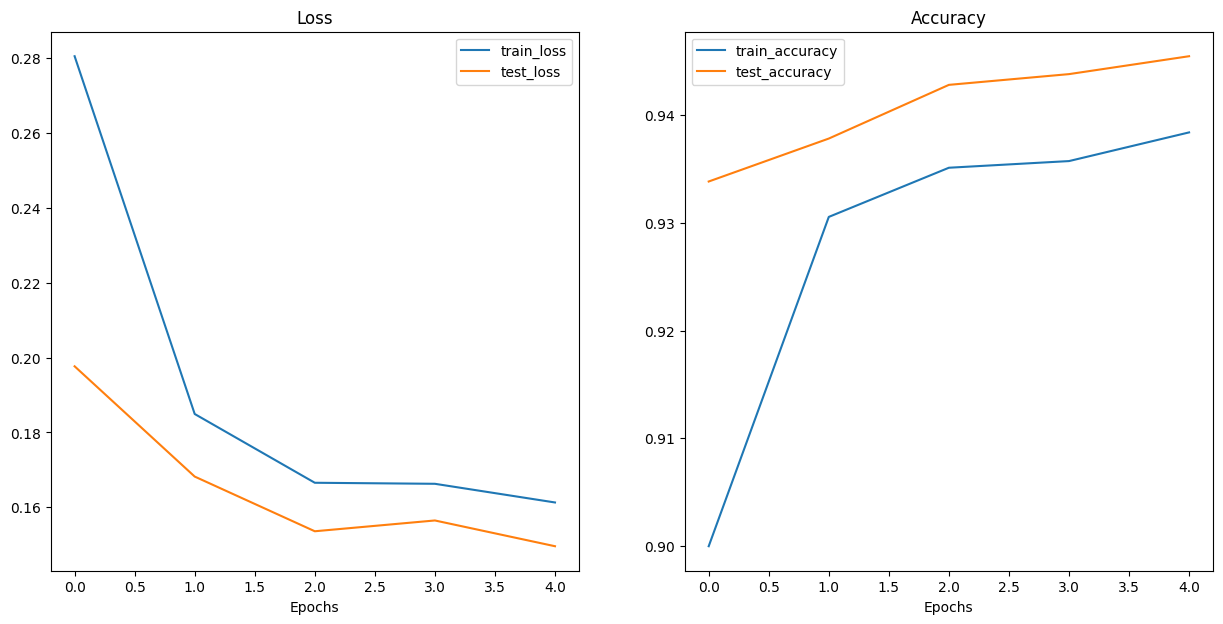

In [19]:
import matplotlib.pyplot as plt


loss = results['train_loss']
test_loss = results['test_loss']
accuracy = results['train_acc']
test_accuracy = results['test_acc']
epochs = range(len(results['train_loss']))

# Setup a plot
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, test_loss, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='train_accuracy')
plt.plot(epochs, test_accuracy, label='test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [20]:
from typing import List, Tuple

from PIL import Image


def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


    model.to(device)
    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

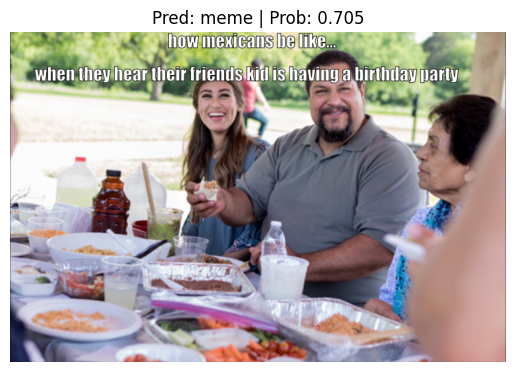

In [22]:
#infer on a custom image

import requests

meme_img="/content/5kdata/test/meme/01547.png"
non_meme="/content/5kdata/test/non-meme/000000001353.jpg"
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=meme_img,
                    class_names=class_names)

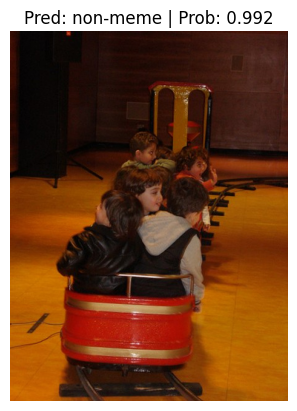

In [23]:
pred_and_plot_image(model=model,
                    image_path=non_meme,
                    class_names=class_names)

In [ ]:
#saving and loading model

model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

model = torch.jit.load('model_scripted.pt')
model.eval()